# Charge Carrier Trapping Experiment

CCT = Charge Carrier Trapping - This is a test of comparing the Zhou et al 2017 results with a data driven analysis using multinest

In [ ]:
%matplotlib inline
from pylab import *;ion()
from pandas import read_csv

from exoparams import PlanetParams
from astropy import units as u

In [ ]:
h38_visit1 = read_csv('HATP38_all/1.125-1.642_LC_negative_first.dat', delimiter='\t', skiprows=[1])
h38_visit2 = read_csv('HATP38_all/1.125-1.642_LC_negative_second.dat', delimiter='\t', skiprows=[1])
w67_visit1 = read_csv('wasp67_all/1.125-1.642_LC_negative.dat', delimiter='\t', skiprows=[1])

In [ ]:
hat38_par  = PlanetParams('HAT-P-38 b')
wasp67_par = PlanetParams('WASP-67 b')
# # hat38_par.t0
# hat38_par.t0 = u.Quantity(2455863.11957, unit=hat38_par.t0.format)

In [ ]:
hat38_per = hat38_par.per.value
hat38_t0  = 2455863.11957 - 2400000.5#hat38_par.t0.value - 2400000.5

wasp67_per = wasp67_par.per.value
wasp67_t0  = wasp67_par.t0.value - 2400000.5

In [ ]:
w67_phase1  = ((w67_visit1['Time [d]'].values - wasp67_t0) % wasp67_per) / wasp67_per
h38_phase1  = ((h38_visit1['Time [d]'].values - hat38_t0 ) % hat38_per ) / hat38_per
h38_phase2  = ((h38_visit2['Time [d]'].values - hat38_t0 ) % hat38_per ) / hat38_per

w67_phase1[w67_phase1 > 0.5] -= 1
h38_phase1[h38_phase1 > 0.5] -= 1
h38_phase2[h38_phase2 > 0.5] -= 1

**Check if the data makes sense as is**

In [ ]:
errorbar(h38_phase1, h38_visit1['Flux'] / median(h38_visit1['Flux']), h38_visit1['Sigma'] / median(h38_visit1['Flux']), fmt='o')
errorbar(h38_phase2, h38_visit2['Flux'] / median(h38_visit2['Flux']), h38_visit2['Sigma'] / median(h38_visit2['Flux']), fmt='o')
errorbar(w67_phase1, w67_visit1['Flux'] / median(w67_visit1['Flux']), w67_visit1['Sigma'] / median(w67_visit1['Flux']), fmt='o')

ylim(.98,1.003)

In [ ]:
def single_exponential_model(params, orbit_phase):
    alpha = params[0]
    beta  = params[1]
    gamma = params[2]
    
    return alpha + beta*exp(-gamma*phase)

In [ ]:
def double_exponential_model(params, orbit_phase):
    alpha   = params[0]
    beta    = params[1]
    gamma   = params[2]
    delta   = params[3]
    epsilon = params[4]
    
    return alpha + beta*exp(-gamma*phase) + delta*exp(-epsilon*phase)

In [ ]:
def zhou_model(params, orbital_phase):
    # Zhou et al. 2017
    # The exponential ramp timescale is detector dependennt, and therfore uniform across all observations
    # But the difference from orbit to orbit is predicted to be related 
    #   ONLY to the inital number of charge traps populated at the start of the each ramp
    

# PyMultiNest Solver Class

**Initial Example**

In [ ]:
run?

In [1]:
#!/usr/bin/env python
from pymultinest.solve import Solver
from numpy import pi, sin

class EggboxProblem(Solver):
    def Prior(self, cube):
        return cube * 10 * pi
    def LogLikelihood(self, cube):
        chi = (sin(cube)).prod()
        return (2. + chi)**5

solution = EggboxProblem(n_dims = 1)
print(solution)
solution = EggboxProblem(n_dims = 2)
print(solution)
# solution = EggboxProblem(n_dims = 3); print(solution)


  analysing data from /var/folders/8r/c8f_w64s30z72t_757dqygmc0001x8/T/tmp94fyzx63pymultinest/.txt
Model in "(temporary directory)" (1 dimensions)
Evidence ln Z = 239.1 +- 0.1
Parameter values:
   Parameter  1 : 13.693 +- 9.049
  analysing data from /var/folders/8r/c8f_w64s30z72t_757dqygmc0001x8/T/tmpxpa0cvdgpymultinest/.txt
Model in "(temporary directory)" (2 dimensions)
Evidence ln Z = 236.0 +- 0.1
Parameter values:
   Parameter  1 : 15.809 +- 8.981
   Parameter  2 : 16.120 +- 9.781


**My PyMultiNest Test**

In [ ]:
%matplotlib inline
from pylab import *;ion()

from pymultinest.solve import Solver,solve
from numpy import pi, sin, cos, linspace

def straight_line(cube):
    offset = cube[0]
    slope  = cube[1]
    return lambda abscissa: offset + slope * abscissa

def sine_wave(cube):
    amp    = cube[0]
    period = cube[1]
    return lambda abscissa: amp*sin(2*pi / period * abscissa)

np.random.seed(0)

param0= 0.1#0.05
param1= 0.1#5*pi
yunc  = 0.1
nPts  = int(10)
nThPts= int(1e3)

xmin  = -0.5*pi
xmax  =  0.5*pi
dx    = 0.1*(xmax - xmin)

# model = sine_wave
model = straight_line

yuncs = np.random.normal(yunc, 1e-2 * yunc, nPts)
thdata= np.linspace(xmin-dx, xmax+dx, nThPts)

xdata = np.random.uniform(xmin, xmax, nPts)
xdata = sort(xdata)

ydata = model([param0,param1])(xdata)

yerr  = np.random.normal(0, yuncs, nPts)
zdata = ydata + yerr

In [ ]:
class ChisqFit(Solver):
    def Prior(self, cube):
        return cube
    
    def LogLikelihood(self, cube):
        chisq = (-0.5*((model(cube)(xdata) - ydata)**2.) )#/ yuncs**2.
        return chisq.prod()

# solution = ChisqFit(n_dims = 2, resume=False, outputfiles_basename='./42-')

solution = ChisqFit(n_dims = 2, n_params=None, n_clustering_params=None, wrapped_params=None        , \
                    importance_nested_sampling=True, multimodal=True, const_efficiency_mode=False   , \
                    n_live_points=400, evidence_tolerance=0.5, sampling_efficiency=0.8              , \
                    n_iter_before_update=100, null_log_evidence=-1e+90, max_modes=100               , \
                    mode_tolerance=-1e+90, outputfiles_basename='chains/1-', seed=-1, verbose=False , \
                    resume=False, context=0, write_output=True, log_zero=-1e+100, max_iter=0         , \
                    init_MPI=True, dump_callback=None)
print(solution)

In [ ]:
figure(figsize=(10,10))
plot(thdata, model([param0,param1])(thdata))
errorbar(xdata, zdata, yunc*ones(zdata.size), fmt='o')

**Simplest Example**

In [ ]:
import pymultinest

def prior(cube, ndim, nparams):
    cube[0] = cube[0] * 2

def loglikelihood(cube, ndim, nparams):
    return -0.5 * ((cube[0] - 0.2) / 0.1)**2

pymultinest.run(loglikelihood, prior, n_dims=1, max_iter=2)

# PyMultiNest Solve Function

In [ ]:
#!/usr/bin/env python
from __future__ import absolute_import, unicode_literals, print_function
import numpy
from numpy import pi, cos
from pymultinest.solve import solve
import os

if not os.path.exists("chains"): os.mkdir("chains")

# probability function, taken from the eggbox problem.

def myprior(cube):
    return cube * 10 * pi

def myloglike(cube):
    chi = (cos(cube / 2.)).prod()
    return (2. + chi)**5

In [ ]:
# number of dimensions our problem has
parameters = ["x", "y"]
n_params = len(parameters)

# run MultiNest
result = solve(LogLikelihood=myloglike, Prior=myprior, 
    n_dims=n_params, outputfiles_basename="chains/3-")

print()
print('evidence: %(logZ).1f +- %(logZerr).1f' % result)
print()
print('parameter values:')
for name, col in zip(parameters, result['samples'].transpose()):
    print('%15s : %.3f +- %.3f' % (name, col.mean(), col.std()))

# PyMultiNest Run Function from Demo_Minimalist

In [ ]:
from __future__ import absolute_import, unicode_literals, print_function
import pymultinest
import math, os
if not os.path.exists("chains"): os.mkdir("chains")

# our probability functions
# Taken from the eggbox problem.

def myprior(cube, ndim, nparams):
    for i in range(ndim):
        cube[i] = cube[i] * 10 * math.pi

def myloglike(cube, ndim, nparams):
    chi = 1.
    for i in range(ndim):
        chi *= math.cos(cube[i] / 2.)
    return math.pow(2. + chi, 5)
#     return (2. + chi)**5

In [ ]:
# number of dimensions our problem has
parameters = ["x", "y"]
n_params = len(parameters)

# run MultiNest
pymultinest.run(myloglike, myprior, n_params, 
    resume = True, verbose = True)

# run 
# $ multinest_marginals.py chains/1-
# which will produce pretty marginal pdf plots

# for code to analyse the results, and make plots see full demo

# PyMultiNest Self-Generated Run Function: 'multinest_marginals.py'

In [ ]:
#!/usr/bin/env python
from __future__ import absolute_import, unicode_literals, print_function
__doc__ = """
Script that does default visualizations (marginal plots, 1-d and 2-d).

Author: Johannes Buchner (C) 2013
"""
import numpy
from numpy import exp, log
import matplotlib.pyplot as plt
import sys, os
import json
import pymultinest

In [ ]:
argv = ['multinest_marginals.py','chains/2-']

if len(argv) != 2:
    sys.stderr.write("""SYNOPSIS: %s <output-root> 

    output-root:     Where the output of a MultiNest run has been written to. 
                    Example: chains/1-
%s""" % (argv[0], __doc__))
    sys.exit(1)

In [ ]:
prefix = argv[1]
print('model "%s"' % prefix)
parameters = json.load(open(prefix + 'params.json'))
n_params = len(parameters)

In [ ]:
a = pymultinest.Analyzer(n_params = n_params, outputfiles_basename = prefix)
s = a.get_stats()

json.dump(s, open(prefix + 'stats.json', 'w'), indent=4)

In [ ]:
print('  marginal likelihood:')
print('    ln Z = %.1f +- %.1f' % (s['global evidence'], s['global evidence error']))
print('  parameters:')
for p, m in zip(parameters, s['marginals']):
    lo, hi = m['1sigma']
    med = m['median']
    sigma = (hi - lo) / 2
    i = max(0, int(-numpy.floor(numpy.log10(sigma))) + 1)
    fmt = '%%.%df' % i
    fmts = '\t'.join(['    %-15s' + fmt + " +- " + fmt])
    print(fmts % (p, med, sigma))

In [ ]:
print('creating marginal plot ...')
p = pymultinest.PlotMarginal(a)

In [ ]:
values = a.get_equal_weighted_posterior()
assert n_params == len(s['marginals'])
modes = s['modes']

In [ ]:
dim2 = os.environ.get('D', '1' if n_params > 20 else '2') == '2'
dim2

In [ ]:
%matplotlib inline
from pylab import *;ion()
nbins = 100 if n_params < 3 else 20
if dim2:
    print('dim2 is True and n_params is', n_params)
    plt.figure(figsize=(5*n_params, 5*n_params))
    for i in range(n_params):
        plt.subplot(n_params, n_params, i + 1)
        plt.xlabel(parameters[i])
    
        m = s['marginals'][i]
        plt.xlim(m['5sigma'])
    
        oldax = plt.gca()
        x,w,patches = oldax.hist(values[:,i], bins=nbins, edgecolor='grey', color='grey', histtype='stepfilled', alpha=0.2)
        oldax.set_ylim(0, x.max())
    
        newax = plt.gcf().add_axes(oldax.get_position(), sharex=oldax, frameon=False)
        p.plot_marginal(i, ls='-', color='blue', linewidth=3)
        newax.set_ylim(0, 1)
    
        ylim = newax.get_ylim()
        y = ylim[0] + 0.05*(ylim[1] - ylim[0])
        center = m['median']
        low1, high1 = m['1sigma']
        #print(center, low1, high1)
        newax.errorbar(x=center, y=y,
            xerr=numpy.transpose([[center - low1, high1 - center]]), 
            color='blue', linewidth=2, marker='s')
        oldax.set_yticks([])
        #newax.set_yticks([])
        newax.set_ylabel("Probability")
        ylim = oldax.get_ylim()
        newax.set_xlim(m['5sigma'])
        oldax.set_xlim(m['5sigma'])
        #plt.close()
    
        for j in range(i):
            plt.subplot(n_params, n_params, n_params * (j + 1) + i + 1)
            p.plot_conditional(i, j, bins=20, cmap = plt.cm.gray_r)
            for m in modes:
                plt.errorbar(x=m['mean'][i], y=m['mean'][j], xerr=m['sigma'][i], yerr=m['sigma'][j])
            plt.xlabel(parameters[i])
            plt.ylabel(parameters[j])
            #plt.savefig('cond_%s_%s.pdf' % (params[i], params[j]), bbox_tight=True)
            #plt.close()

    plt.savefig(prefix + 'marg.pdf')
    plt.savefig(prefix + 'marg.png')
    plt.close()
else:
    from matplotlib.backends.backend_pdf import PdfPages
    sys.stderr.write('1dimensional only. Set the D environment variable \n')
    sys.stderr.write('to D=2 to force 2d marginal plots.\n')
    pp = PdfPages(prefix + 'marg1d.pdf')
    
    for i in range(n_params):
        plt.figure(figsize=(3, 3))
        plt.xlabel(parameters[i])
        plt.locator_params(nbins=5)
        
        m = s['marginals'][i]
        iqr = m['q99%'] - m['q01%']
        xlim = m['q01%'] - 0.3 * iqr, m['q99%'] + 0.3 * iqr
        #xlim = m['5sigma']
        plt.xlim(xlim)
    
        oldax = plt.gca()
        x,w,patches = oldax.hist(values[:,i], bins=numpy.linspace(xlim[0], xlim[1], 20), edgecolor='grey', color='grey', histtype='stepfilled', alpha=0.2)
        oldax.set_ylim(0, x.max())
    
        newax = plt.gcf().add_axes(oldax.get_position(), sharex=oldax, frameon=False)
        p.plot_marginal(i, ls='-', color='blue', linewidth=3)
        newax.set_ylim(0, 1)
    
        ylim = newax.get_ylim()
        y = ylim[0] + 0.05*(ylim[1] - ylim[0])
        center = m['median']
        low1, high1 = m['1sigma']
        #print center, low1, high1
        newax.errorbar(x=center, y=y,
            xerr=numpy.transpose([[center - low1, high1 - center]]), 
            color='blue', linewidth=2, marker='s')
        oldax.set_yticks([])
        newax.set_ylabel("Probability")
        ylim = oldax.get_ylim()
        newax.set_xlim(xlim)
        oldax.set_xlim(xlim)
        plt.savefig(pp, format='pdf', bbox_inches='tight')
        plt.close()
    pp.close()

# PyMultiNest Demo Script -- Full

In [6]:
from __future__ import absolute_import, unicode_literals, print_function
import pymultinest
import math
import os
import threading, subprocess
from sys import platform

if not os.path.exists("chains"): os.mkdir("chains")
    

<Container object of 3 artists>

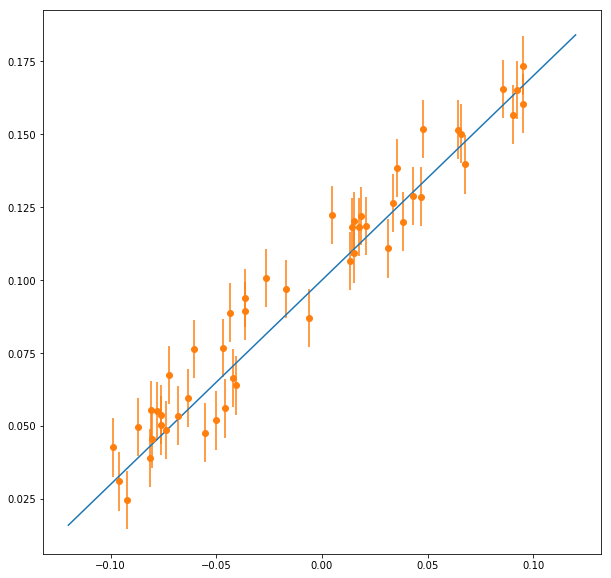

In [113]:
%matplotlib inline
from pylab import *;ion()

from pymultinest.solve import Solver,solve
from numpy import pi, sin, cos, linspace

def straight_line(cube):
    offset = cube[0]
    slope  = cube[1]
    return lambda abscissa: offset + slope * abscissa

def sine_wave(cube):
    amp    = cube[0]
    period = cube[1]
    return lambda abscissa: amp*sin(2*pi / period * abscissa)

np.random.seed(0)

param0= 0.1#0.05
param1= 0.7#5*pi
yunc  = 0.01
nPts  = int(50)
nThPts= int(1e3)

xmin  = -0.1#*pi
xmax  =  0.1#*pi
dx    = 0.1*(xmax - xmin)

# model = sine_wave
model = straight_line

yuncs = np.random.normal(yunc, 1e-2 * yunc, nPts)
thdata= np.linspace(xmin-dx, xmax+dx, nThPts)

xdata = np.random.uniform(xmin, xmax, nPts)
xdata = sort(xdata)

ydata = model([param0,param1])(xdata)

yerr  = np.random.normal(0, yuncs, nPts)
zdata = ydata + yerr

figure(figsize=(10,10))
plot(thdata, model([param0,param1])(thdata))
errorbar(xdata, zdata, yunc*ones(zdata.size), fmt='o')

In [153]:
rm -rf chains/*

In [154]:
# our probability functions
# Taken from the eggbox problem.
# model = sine_wave
# parameters = ["amp", "period"]

# model = straight_line
# parameters = ["offset", "slope"]

def myprior(cube, ndim, nparams):
    #print "cube before", [cube[i] for i in range(ndim)]
    for i in range(ndim):
        cube[i] = cube[i]# U(0,1) -- default
    #print "python cube after", [cube[i] for i in range(ndim)]

def myloglike(cube, ndim, nparams):
    chi = 1.
    # print "cube", [cube[i] for i in range(ndim)], cube
    # for i in range(ndim):
    #     chi *= -0.5 * ((cube[i] - 0.2) / 0.1)**2#math.cos(cube[i] / 2.) * math.sin(cube[i] / 2.)
    # print "returning", math.pow(2. + chi, 5)
    modelNow = model(cube)(xdata)
    return -0.5*((modelNow - ydata)**2. / yuncs**2.).sum()

  analysing data from chains/2-.txt


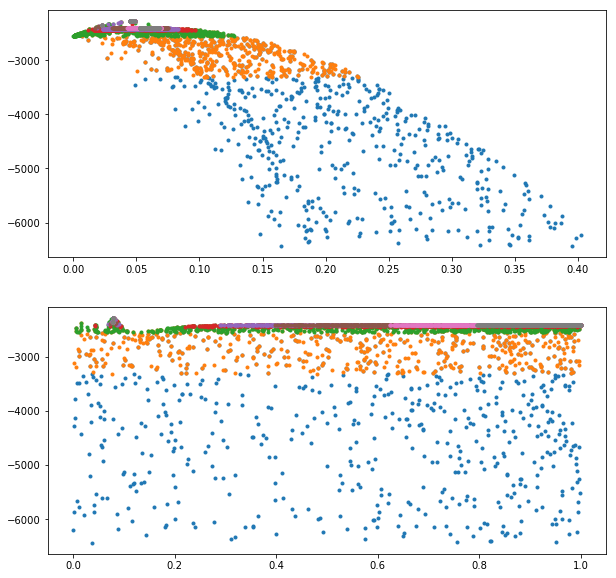

In [155]:
# number of dimensions our problem has
# parameters = ["x", "y"]
n_params = len(parameters)

plt.figure(figsize=(5*n_params, 5*n_params))
# we want to see some output while it is running
progress = pymultinest.ProgressPlotter(n_params = n_params, outputfiles_basename='chains/2-'); progress.start()
# threading.Timer(2, show, ["chains/2-phys_live.points.pdf"]).start() # delayed opening
# run MultiNest
pymultinest.run(myloglike, myprior, n_params, importance_nested_sampling = False, resume = True, verbose = True, \
            sampling_efficiency = 'model', n_live_points = 1000, outputfiles_basename='chains/2-')

# ok, done. Stop our progress watcher
progress.stop()

# lets analyse the results
a = pymultinest.Analyzer(n_params = n_params, outputfiles_basename='chains/2-')
s = a.get_stats()

In [156]:
import json

# store name of parameters, always useful
with open('%sparams.json' % a.outputfiles_basename, 'w') as f:
    json.dump(parameters, f, indent=2)
# store derived stats
with open('%sstats.json' % a.outputfiles_basename, mode='w') as f:
    json.dump(s, f, indent=2)

print()
print("-" * 30, 'ANALYSIS', "-" * 30)
print("Global Evidence:\n\t%.15e +- %.15e" % ( s['nested sampling global log-evidence'], s['nested sampling global log-evidence error'] ))


------------------------------ ANALYSIS ------------------------------
Global Evidence:
	-2.296324781335745e+03 +- 1.010088666315045e-01


Take a look at the pdf files in chains/


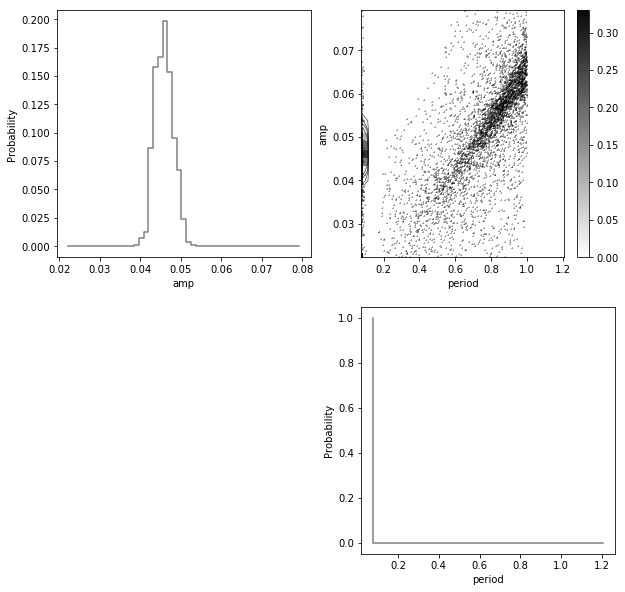

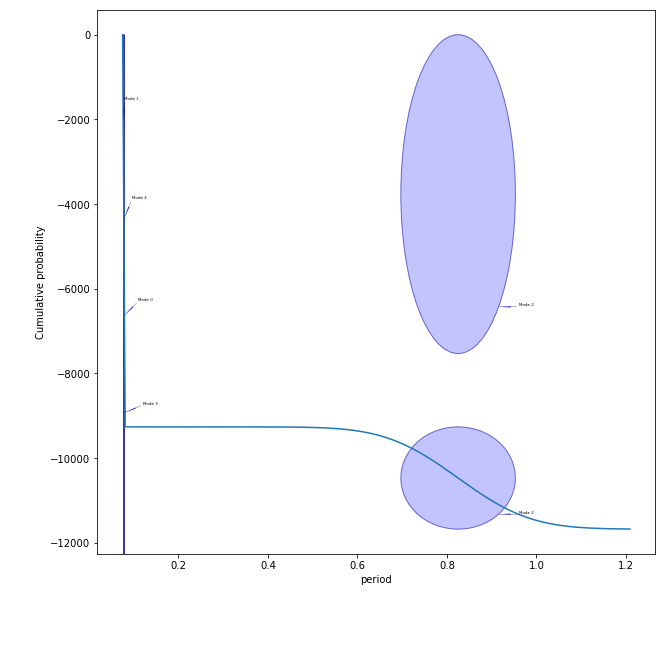

In [159]:
import matplotlib.pyplot as plt
plt.clf()

# Here we will plot all the marginals and whatnot, just to show off
# You may configure the format of the output here, or in matplotlibrc
# All pymultinest does is filling in the data of the plot.

# Copy and edit this file, and play with it.

p = pymultinest.PlotMarginalModes(a)
plt.figure(figsize=(5*n_params, 5*n_params))
#plt.subplots_adjust(wspace=0, hspace=0)
for i in range(n_params):
    plt.subplot(n_params, n_params, n_params * i + i + 1)
    p.plot_marginal(i, with_ellipses = True, with_points = False, grid_points=50)
    plt.ylabel("Probability")
    plt.xlabel(parameters[i])
    
    for j in range(i):
        plt.subplot(n_params, n_params, n_params * j + i + 1)
        #plt.subplots_adjust(left=0, bottom=0, right=0, top=0, wspace=0, hspace=0)
        p.plot_conditional(i, j, with_ellipses = False, with_points = True, grid_points=30)
        plt.xlabel(parameters[i])
        plt.ylabel(parameters[j])

# plt.savefig("chains/marginals_multinest.pdf") #, bbox_inches='tight')
# show("chains/marginals_multinest.pdf")

plt.figure(figsize=(5*n_params, 5*n_params))
plt.subplot2grid((5*n_params, 5*n_params), loc=(0,0))
for i in range(n_params):
    #plt.subplot(n_params, n_params, i + 1)
    # outfile = '%s-mode-marginal-%d.pdf' % (a.outputfiles_basename,i)
    p.plot_modes_marginal(i, with_ellipses = True, with_points = False)
    plt.ylabel("Probability")
    plt.xlabel(parameters[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()
    
    # outfile = '%s-mode-marginal-cumulative-%d.pdf' % (a.outputfiles_basename,i)
    p.plot_modes_marginal(i, cumulative = True, with_ellipses = True, with_points = False)
    plt.ylabel("Cumulative probability")
    plt.xlabel(parameters[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()

print("Take a look at the pdf files in chains/") 

In [167]:
p.analyser.get_best_fit()['parameters'], [param0, param1]

([0.04686648151499874, 0.078717987667749442], [0.1, 0.7])